In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
import yfinance as yf
import tensorflow as tf
import pyodbc
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')

from utils.data_extraction import load_data
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final,\
                                    generateFeatures_final
from utils.preprocessing_features_and_labels import extract_labels,\
                                                    align_features_and_labels,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\PC\Anaconda3\lib\site-packages\tensorflow_core\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\PC\Anaconda3\lib\site-packages\tensorflow_core\python\pywrap_tensorflow_internal.py", line 2453, in <module>
    from tensorflow.python.util import deprecation
  File "C:\Users\PC\Anaconda3\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 25, in <module>
    from tensorflow.python.platform import tf_logging as logging
ImportError: cannot import name 'tf_logging' from 'tensorflow.python.platform' (C:\Users\PC\Anaconda3\lib\site-packages\tensorflow\python\platform\__init__.py)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File

TypeError: can only concatenate str (not "list") to str

### Load data etc

In [ ]:
stockInfo = pd.read_csv('../utils/stockInfo.csv',header=[0,1])

In [ ]:
# How many are there contained in the file?
print('There is',
      stockInfo.shape[0],
      'tickers contained in the file, and there is data on',
      stockInfo.isnull().sum()[1:].min(),'of them.')

## Sneak peak on the 10 largest companies

In [ ]:

stockInfo.sort_values(('2020-07-05','marketCap'),ascending=False).head(10)

## How is the tickers divided in sectors?

In [ ]:
stockInfo.loc[:,('2020-07-05')].groupby(['sector']).count()#rename(None,axis=1)

## Lets get the X largest companies in each sector.

In [2]:
sectors = stockInfo.loc[:,('2020-07-05')].dropna(axis=0).sector.unique()

X = 5

topXsectors = pd.DataFrame(index = np.arange(X),columns = pd.MultiIndex.from_product([['Top {}'.format(X)],sectors]))

t1 = pd.DataFrame({'tickers':stockInfo.loc[:,'date'].ticker.values})
t1[stockInfo.loc[:,'2020-07-05'].columns] = stockInfo.loc[:,'2020-07-05']

for i,sector in enumerate(sectors):
    
    tempSec = t1[t1.sector==sector].sort_values('marketCap',
                                                      ascending=False).dropna(axis=0).values.T
    
    Y = len(tempSec[0][0:X]) 

    topXsectors.loc[0:(Y-1),('Top {}'.format(X),sector)] = tempSec[0][0:Y]

NameError: name 'stockInfo' is not defined

In [42]:
topXsectors

Top 5                                                 \
  Healthcare Basic Materials Consumer Defensive Industrials   
0        JNJ             BHP                WMT         UNP   
1        NVS             LIN                 KO          BA   
2        PFE             ECL                PEP         LMT   
3       ABBV             APD               COST         UPS   
4        ABT             SHW                FMX         RTX   

                                                                         \
  Financial Services Technology Consumer Cyclical Real Estate Utilities   
0                  V       AAPL              BABA         AMT         D   
1                 MA       MSFT              TSLA         CCI        SO   
2               PYPL        TSM                TM         PLD       AEP   
3                BAC       INTC               NKE         PSA       EXC   
4                LFC       NVDA               MCD        CSGP       SRE   

                                           
  Communication Services Energy Financial  
0                   GOOG    PTR       IIM  
1                     FB     BP       ZTR  
2                      T    SNP      OTTW  
3                    DIS    ENB       NaN  
4                    CHL    PBR       NaN

## Let's extract some data now!

In [50]:
# print(os.listdir())
try:
    path = 'a:/taqhdf5'  #'a:/taqhdf5'
    os.listdir(path)
except:
    path = 't:/taqhdf5'  #'a:/taqhdf5'
    os.listdir(path)    
# allFiles = os.listdir(path)
# print(len(allFiles), allFiles[:5], allFiles[-5:])
# print(allFiles[-10:])

dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,32)]).astype(int)
# dates = np.array(['20200401']).astype(int)#,'20200402','20200403','20200406','20200407'

# Provide a list of tickers of interest
tickers = ['GOOG']#'MSFT'

# Do we need data on trades, quotes or both?
dataNeeded = 'trades' # 'trades', 'quotes' or 'both'

# run load_data()
if dataNeeded == 'trades':
    tradeData = load_data(dates, tickers, dataNeeded, path, verbose)
elif dataNeeded == 'quotes':
    quoteData = load_data(dates, tickers, dataNeeded, path, verbose)
elif dataNeeded == 'both':
    tradeData, quoteData = load_data(dates, tickers, dataNeeded, path, verbose)

['.ipynb_checkpoints', 'Old Versions', 'preprocessing.ipynb', 'Quote_vs_trade_candles.ipynb', 'testing_and_comparing_candlesticks.ipynb', 'testing_features.ipynb', 'testing_preprocessing_features_and_labels.ipynb']
8545 ['taq_19930315.h5', 'taq_19930104.h5', 'taq_19930317.h5', 'taq_19930105.h5', 'taq_19930316.h5'] ['taqtrade_20200624.h5', 'taqtrade_20200629.h5', 'taqquote_20200602.h5', 'taqquote_20200605.h5', 'taqquote_20200610.h5']
['taqtrade_20200605.h5', 'taqtrade_20200609.h5', 'taqtrade_20200611.h5', 'taqtrade_20200616.h5', 'taqtrade_20200619.h5', 'taqtrade_20200624.h5', 'taqtrade_20200629.h5', 'taqquote_20200602.h5', 'taqquote_20200605.h5', 'taqquote_20200610.h5']
##### Date range #####

Date, Min: 20200401
Date, Max: 20200431

##### Data Extraction begins #####

trade data is being extracted..

### Trade Data ###

The raw H5 trade file contains:  ['TradeIndex', 'Trades'] 

Ticker Information:  (b'GOOG            ', 26900500, 71427) 

Sneak peak of the data

            utcsec ex 

## Data Cleaning, Feature Engineering & Pre Processing

# Implemented technical features

A library: https://technical-analysis-library-in-python.readthedocs.io/en/latest/

### Features used in the literature:

* Stochastic K
* Stochastic D
* Slow Stochastic D
* Momentum/difference
* ROC
* Williams % R
* A/D Oscillator
* Disparity 5
* Disparity 10
* Price Oscillator - (detrended)
* Commodity Channel Index
* RSI

Formulas: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=876544

* Moving Average
* Exponential Moving Average
* True Range - (Average)

Formulas: https://www.sciencedirect.com/science/article/pii/S0957417407001819?via%3Dihub

#### Other Technical Features
* Moving Average Convergence Divergence (MACD)

**Non-classical technical features** - **NOT IMPLEMENTED**

* Bid/Ask prices of top of book
* Spread and mid price based on top og book
* Price derivatives

Formulas: https://www.tandfonline.com/doi/full/10.1080/14697688.2015.1032546?instName=UCL+%28University+College+London%29

In [69]:
########### Clean data ###########
    
DATA_SAMPLE = 'full' # or 'stable'

if DATA_SAMPLE == 'stable':
    # P1 is used for keeping data within [9.5, 16]
    cleanedData = HFDataCleaning(['P1','p2','t1','p3'],tradeData,'trade',['q'])
elif DATA_SAMPLE == 'full':
    # P1_2 is used for keeping data within [9, 16.5]
    cleanedData = HFDataCleaning(['P1_2','p2', 't1', 'p3'],tradeData,'trade',['q'])#'t1',tradeData # q2, quotedate
    
########### Construct Candles ################
# candles = candleCreateNP_vect_final(cleanedData
#                          ,1)

candles = candleCreateNP_vect_final(data = cleanedData,
                                       step = 1,
                                        verbose=False,
                                        fillHoles=True,
                                        sample='stable',
                                        numpied=True)

########### Generate Features ################

n_feature_lags = 0
features = generateFeatures_final(data = candles, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'stok',
                                                    'stod',
                                                    'sstod',
                                                    'wilr',
                                                    'roc',
                                                    'rsi',
                                                    'atr',
                                                    'cci',
                                                    'dpo',
                                                    'sma',
                                                    'ema',
                                                    'macd',
                                                    'dis5',
                                                    'dis10',
                                                   ], 
                                   feature_lags = n_feature_lags)

########### Generate Labels ################

n_classes = 3

labels = extract_labels(data = candles, classes = n_classes, group_style = 'equal')

########### Align Data ################

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y = align_features_and_labels(candles = candles, 
                                 prediction_horizon = 1, 
                                 features = features, 
                                 n_feature_lags = n_feature_lags, 
                                 n_classes = n_classes, # 5,
                                 safe_burn_in = False, 
                                 data_sample = 'full')

## Let's investigate the features a little bit

In [7]:
X.describe()

,open_lag0,high_lag0,low_lag0,close_lag0,stok_lag0,stod_lag0,sstod_lag0,wilr_lag0,roc_lag0,rsi_lag0,...,atr_lag5,cci_lag5,dpo_lag5,sma_lag5,ema_lag5,macd_lag5,macd_diff_lag5,macd_signal_lag5,dis5_lag5,dis10_lag5
count,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8.151000e+03,8151.000000,8151.000000,8151.000000,8151.000000,...,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000
mean,1232.705101,1233.456892,1231.935172,1232.703159,52.681988,5.268138e+01,52.642132,-47.318012,0.028241,51.190218,...,1.570900,5.548864,-0.040461,1232.413966,1232.414681,0.183515,0.001065,0.182450,100.004541,100.010114
std,65.838826,65.740651,65.947922,65.840834,32.274320,3.027833e+01,24.263828,32.274320,0.526921,13.154166,...,0.801761,112.741777,2.521165,65.799244,65.772941,2.079254,0.631585,1.956223,0.165825,0.256808
min,1080.055000,1081.145000,1079.665000,1080.155000,0.000000,1.979898e-13,3.799185,-100.000000,-2.886946,7.905906,...,0.513762,-500.079470,-58.668500,1082.186250,1082.479799,-9.010780,-4.158530,-7.832363,98.901425,98.614091
25%,1199.587500,1200.417500,1198.775000,1199.542500,22.318774,2.393214e+01,31.906291,-77.681226,-0.186311,42.194052,...,1.065342,-82.784782,-0.909125,1199.208750,1199.327015,-0.723028,-0.240647,-0.685000,99.944022,99.908392
50%,1252.035000,1252.805000,1251.265000,1252.035000,54.359244,5.425685e+01,54.088921,-45.640756,0.014150,51.268510,...,1.348301,13.483332,0.003750,1252.116667,1251.964224,0.092719,-0.015170,0.092665,100.004316,100.008289
75%,1275.607500,1276.147500,1275.100000,1275.615000,83.504105,8.167059e+01,73.296661,-16.495895,0.205312,60.592091,...,1.838060,93.801932,0.888250,1275.695417,1275.615388,0.903346,0.230015,0.847296,100.059515,100.097040
max,1358.785000,1359.770000,1357.935000,1358.925000,100.000000,1.000000e+02,96.431092,-0.000000,9.032843,93.307902,...,9.459971,666.666667,44.235250,1357.860417,1357.353855,28.678742,13.116018,23.872068,106.719083,107.680183


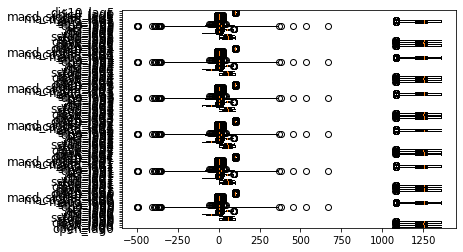

In [8]:
# plt.figure(figsize=(10,10))
plt.boxplot(X.values,vert=False)
plt.yticks(np.arange(1,X.shape[1]+1),
           X.columns,fontsize=12)
plt.show()

## Standardization, Normalization (MinMax), Norm-Scaling, Quantile and Power Transformation

**Inspiration:**

* [ScikitLearn Overview](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)
* [A Note on Feature Scaling and Normalization](http://sebastianraschka.com/Articles/2014_about_feature_scaling.html)

In [61]:
# Setting up the Scalers!
mm_scaler = MinMaxScaler()
scaler = StandardScaler()
norm_scaler = Normalizer()
pt = PowerTransformer()
ptNst = PowerTransformer(standardize=False)
qtUni = QuantileTransformer(n_quantiles=100)
qtGau = QuantileTransformer(n_quantiles=100,output_distribution='normal')
robo = RobustScaler()


For now, we remove features if they are easily scaled down to a desireable range, thereby focusing on the rest.
Features are listed below, as good down-scaling procedures are identified. 

Parentheses indicates that the scaling procedure could work but it is not ideal.

**Open**: Std, Power (Std.), (MinMax) <br>
**High**: Std, Power (Std.), (MinMax)<br>
**Low**: Std, Power (Std.), (MinMax)<br>
**Close**: Std, Power (Std.), (MinMax)<br>
**Stok**: Std, Power (Std.), (MinMax), (Norm)<br>
**Stod**: Std, Power (Std.), (MinMax), (Norm)<br>
**SStod**: Std, Power (Std.), (MinMax), (Norm)<br>
**Wilr**: Std, Power (Std.), (MinMax), (Norm)<br>
**ema**: Std, Power (Std.), (MinMax)<br>
**sma**: Std, Power (Std.), (MinMax)<br>
**Dis5**: Substract 100 <br>
**Dis10**: Substract 100 <br>
**Macd_diff**: baseline <br>
**Roc**: baseline demeaned<br>
**Atr**: baseline demeaned <br>
**Rsi**: Std., Quantile Transformation (Gaussian), Power (Std.) <br>
**Cci**: Quantile Transformation (Gaussian), (Power (Std.)) <br>
**Dpo**: Quantile Transformation (Gaussian),  (Norm) <br>
**Macd**: Quantile Transformation (Gaussian) <br>
**Macd_Signal**: Quantile Transformation (Gaussian) <br>


In [70]:
# tempX = X.drop(columns=['open',
#                         'high',
#                         'low',
#                         'close',
#                         'stok',
#                         'stod',
#                         'sstod',
#                         'wilr',
#                         'sma',
#                         'ema',
#                         'dis5',
#                         'dis10',
#                         'macd_diff',
#                         'roc',
#                         'atr',
#                         'rsi']).copy(deep=True)
tempX = X.copy(deep=True)

In [67]:
tempX.describe()

,open_lag0,high_lag0,low_lag0,close_lag0,stok_lag0,stod_lag0,sstod_lag0,wilr_lag0,roc_lag0,rsi_lag0,...,atr_lag5,cci_lag5,dpo_lag5,sma_lag5,ema_lag5,macd_lag5,macd_diff_lag5,macd_signal_lag5,dis5_lag5,dis10_lag5
count,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8.151000e+03,8151.000000,8151.000000,8151.000000,8151.000000,...,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000,8151.000000
mean,1232.696161,1233.376378,1231.986045,1232.684743,52.520241,5.251936e+01,52.479199,-47.479759,0.028285,51.047264,...,1.525800,5.762215,-0.040370,1232.395297,1232.395989,0.183717,0.001064,0.182653,100.004548,100.010128
std,65.843459,65.780694,65.918905,65.856646,32.569614,3.041830e+01,24.251622,32.569614,0.529048,12.630987,...,0.773459,112.314635,2.538452,65.815006,65.788603,2.082944,0.633812,1.959266,0.166951,0.258131
min,1080.010000,1080.800000,1079.780000,1079.880000,0.000000,1.219765e-13,3.882960,-100.000000,-2.896472,10.633332,...,0.543539,-536.642963,-59.749500,1081.999167,1082.265928,-8.987732,-4.180436,-7.829401,98.843022,98.559192
25%,1199.590000,1200.210000,1198.760000,1199.570000,22.003754,2.350795e+01,31.660256,-77.996246,-0.187800,42.484549,...,1.054834,-81.297776,-0.933250,1199.194583,1199.328542,-0.728663,-0.244001,-0.691285,99.941712,99.908169
50%,1251.930000,1252.690000,1251.280000,1251.960000,54.376658,5.407961e+01,53.864250,-45.623342,0.016798,51.175290,...,1.328626,14.120345,-0.005000,1252.054167,1251.961299,0.093018,-0.016066,0.098722,100.003566,100.007622
75%,1275.645000,1276.075000,1275.120000,1275.620000,82.985923,8.198961e+01,73.411488,-17.014077,0.204589,59.866106,...,1.691335,93.491310,0.891750,1275.687917,1275.605591,0.908579,0.233037,0.854986,100.060402,100.097404
max,1358.565000,1360.000000,1358.130000,1358.790000,100.000000,1.000000e+02,95.943559,-0.000000,9.066019,92.567373,...,9.703080,666.666667,43.795000,1357.719167,1357.329574,28.679766,13.126366,23.858974,106.706318,107.654596


## Baseline

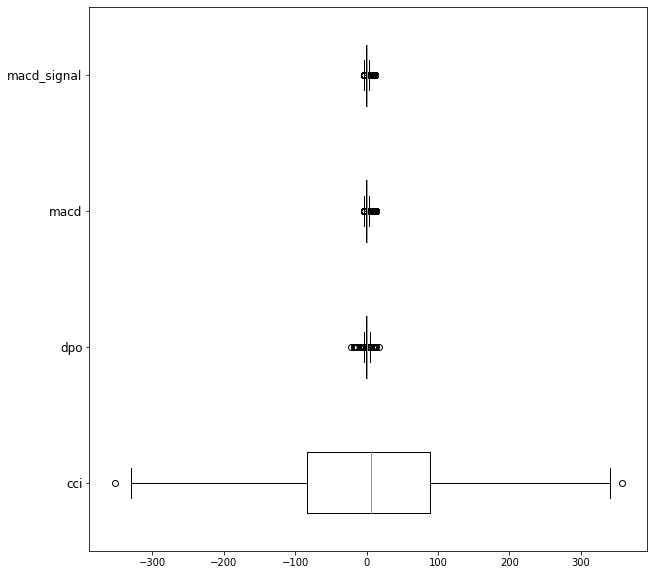

In [142]:
# tempX = tempX.drop(columns=['cci'])
plt.figure(figsize=(10,10))
plt.boxplot(tempX.values,vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

In [130]:
val = tempX.roc
print('Min: ',round(val.min(),3),
      '\nMax: ',round(val.max(),3),
      '\nMedian: ',round(val.median(),3),
      '\nMean: ',round(val.mean(),3))

AttributeError: 'DataFrame' object has no attribute 'roc'

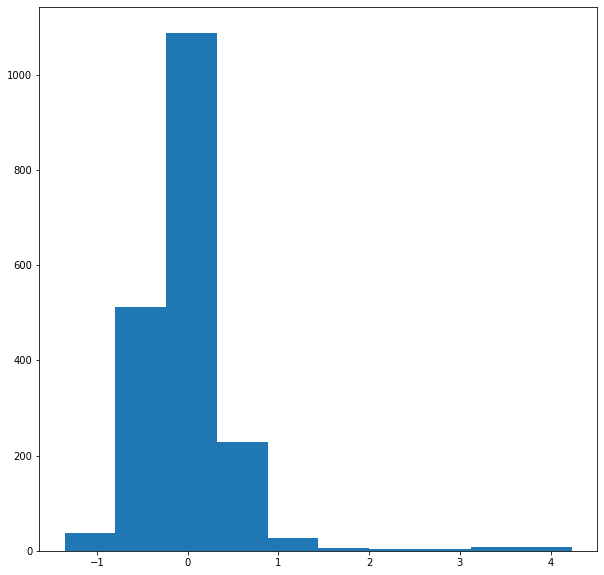

In [131]:
plt.figure(figsize=(10,10))
plt.hist((val-val.mean()))#-tempX.atr.mean()
plt.show()

## Standardization

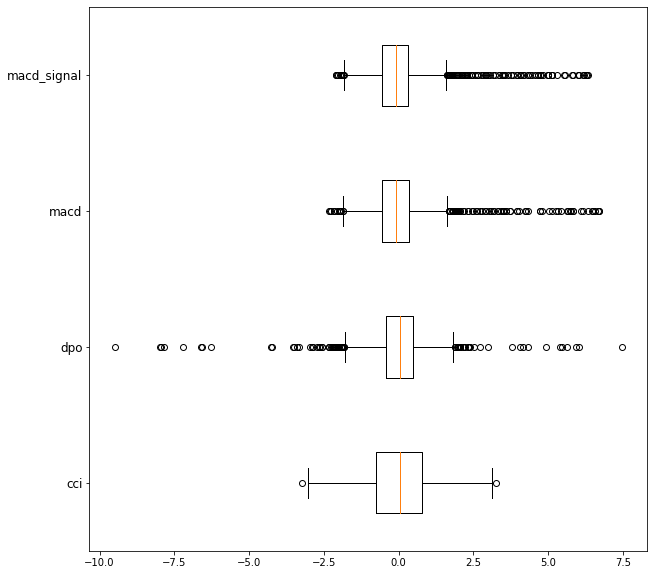

In [132]:
plt.figure(figsize=(10,10))
plt.boxplot(scaler.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Normalization

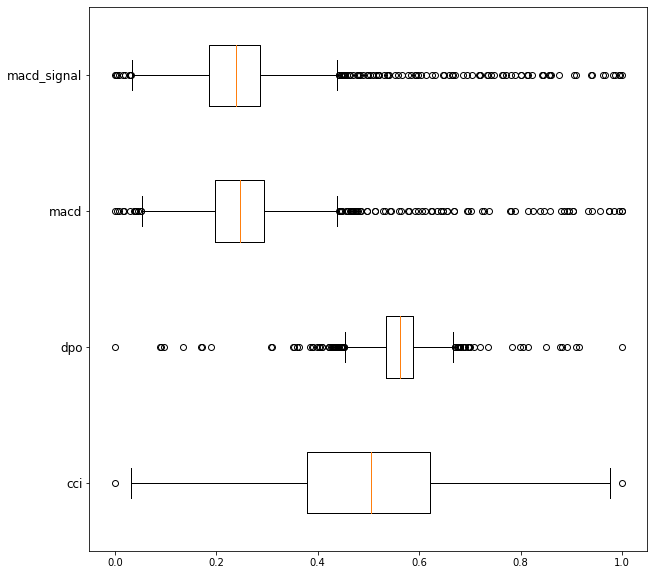

In [133]:
plt.figure(figsize=(10,10))
plt.boxplot(mm_scaler.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Norm-Scaling

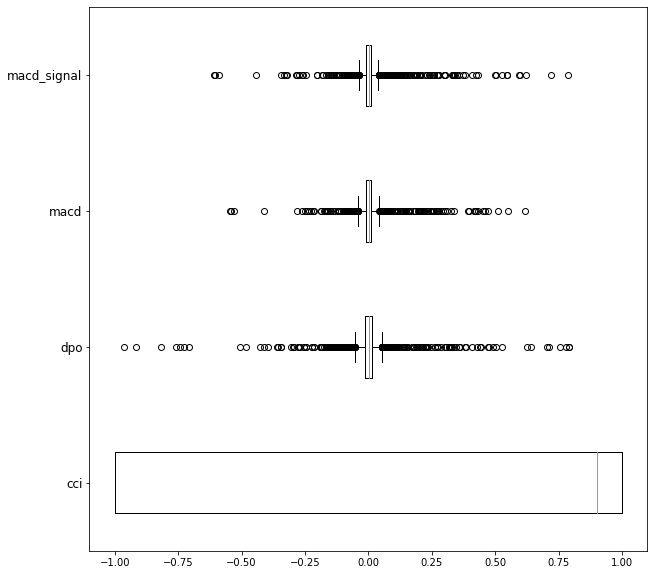

In [134]:
plt.figure(figsize=(10,10))
plt.boxplot(norm_scaler.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Quantile Transformation (Uniform)

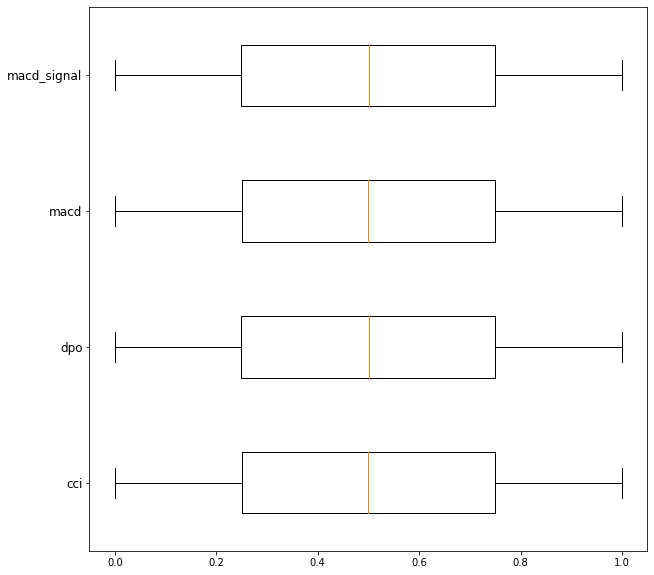

In [135]:
plt.figure(figsize=(10,10))
plt.boxplot(qtUni.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Quantile Transform (Gaussian)

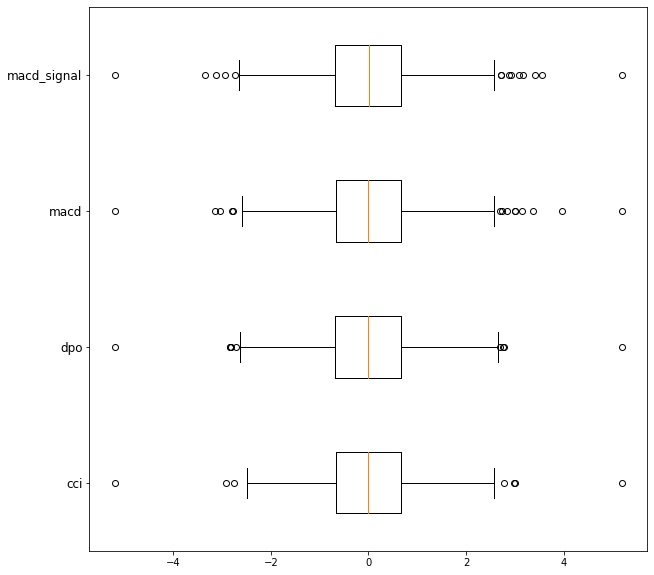

In [136]:
plt.figure(figsize=(10,10))
plt.boxplot(qtGau.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Power Transformation (Standardized)

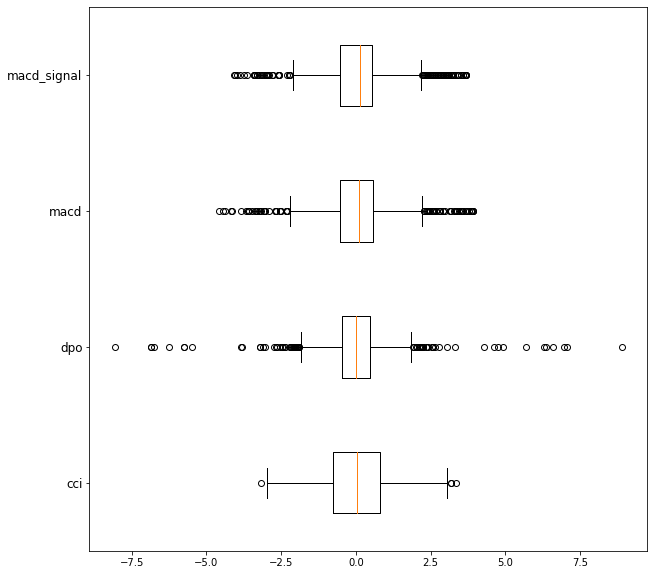

In [137]:
plt.figure(figsize=(10,10))
plt.boxplot(pt.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Power (Not Standardized)

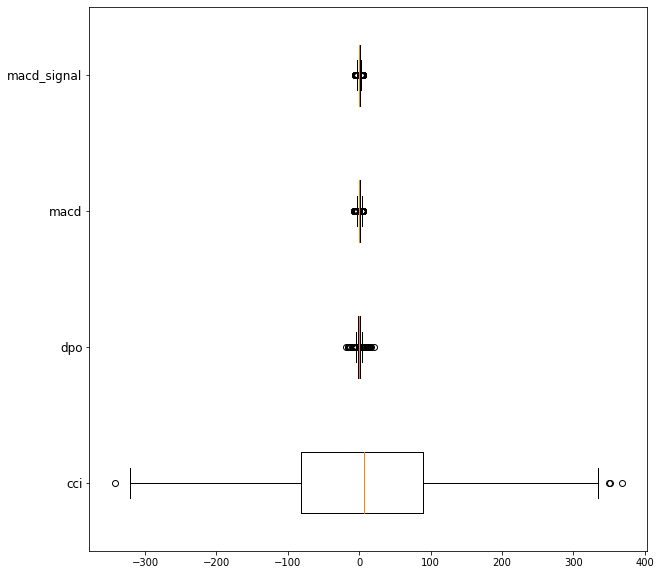

In [138]:
# tempX = tempX.drop(columns=['cci'])
plt.figure(figsize=(10,10))
plt.boxplot(ptNst.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Robust Scaler

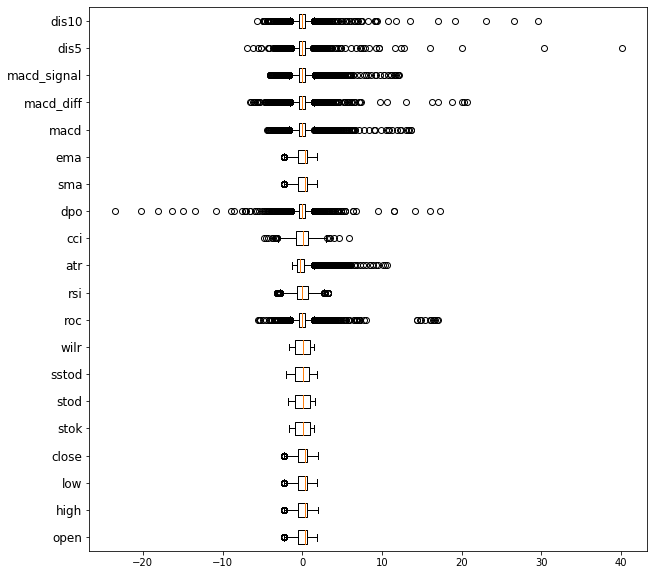

In [79]:
# tempX = tempX.drop(columns=['cci'])
plt.figure(figsize=(10,10))
plt.boxplot(robo.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

In [77]:
pd.DataFrame(scaler.fit_transform(robo.fit_transform(tempX)),columns = tempX.columns).describe()

,open,high,low,close,stok,stod,sstod,wilr,roc,rsi,atr,cci,dpo,sma,ema,macd,macd_diff,macd_signal,dis5,dis10
count,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03,8.156000e+03
mean,-5.721814e-16,6.533927e-19,-1.032633e-16,1.338557e-15,2.052742e-17,-5.741688e-17,6.275292e-17,2.384883e-17,-5.101908e-17,-7.421452e-17,2.492421e-16,-2.308654e-17,-6.152781e-18,-1.312094e-15,2.402797e-15,2.913042e-18,2.722469e-18,1.270032e-17,2.319544e-17,2.872205e-17
std,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00
min,-2.316513e+00,-2.317110e+00,-2.306591e+00,-2.317904e+00,-1.612667e+00,-1.726587e+00,-2.002331e+00,-1.612667e+00,-5.529742e+00,-3.200080e+00,-1.270587e+00,-4.827639e+00,-2.351491e+01,-2.285135e+00,-2.281962e+00,-4.403600e+00,-6.591983e+00,-4.090726e+00,-6.955950e+00,-5.616233e+00
25%,-5.019282e-01,-5.036091e-01,-5.029841e-01,-5.020921e-01,-9.370225e-01,-9.535732e-01,-8.590747e-01,-9.370225e-01,-4.086417e-01,-6.780777e-01,-6.090921e-01,-7.755242e-01,-3.517393e-01,-5.049364e-01,-5.033420e-01,-4.382339e-01,-3.872558e-01,-4.457825e-01,-3.766634e-01,-3.955698e-01
50%,2.928705e-01,2.942798e-01,2.929922e-01,2.932075e-01,5.607458e-02,5.146057e-02,5.730247e-02,5.607458e-02,-2.167974e-02,9.867677e-03,-2.544476e-01,7.528455e-02,1.460327e-02,2.978315e-01,2.963289e-01,-4.341116e-02,-2.774844e-02,-4.256654e-02,-6.248431e-03,-1.080486e-02
75%,6.529111e-01,6.496188e-01,6.549340e-01,6.526517e-01,9.354530e-01,9.687551e-01,8.630693e-01,9.354530e-01,3.334788e-01,6.980415e-01,2.148241e-01,7.801422e-01,3.677769e-01,6.566872e-01,6.556019e-01,3.481599e-01,3.657881e-01,3.431973e-01,3.344275e-01,3.372402e-01
max,1.911611e+00,1.924927e+00,1.913600e+00,1.914842e+00,1.457908e+00,1.561537e+00,1.792590e+00,1.457908e+00,1.708792e+01,3.288130e+00,1.057567e+01,5.880007e+00,1.726478e+01,1.902367e+00,1.897131e+00,1.367933e+01,2.068621e+01,1.208722e+01,4.012839e+01,2.958164e+01


In [139]:
stop

NameError: name 'stop' is not defined

This below list was generated above, now we try to implement the output.

Parentheses indicates that the scaling procedure could work but it is not ideal.

**Open**: Std, Power (Std.), (MinMax) <br>
**High**: Std, Power (Std.), (MinMax)<br>
**Low**: Std, Power (Std.), (MinMax)<br>
**Close**: Std, Power (Std.), (MinMax)<br>
**Stok**: Std, Power (Std.), (MinMax), (Norm)<br>
**Stod**: Std, Power (Std.), (MinMax), (Norm)<br>
**SStod**: Std, Power (Std.), (MinMax), (Norm)<br>
**Wilr**: Std, Power (Std.), (MinMax), (Norm)<br>
**ema**: Std, Power (Std.), (MinMax)<br>
**sma**: Std, Power (Std.), (MinMax)<br>
**Dis5**: Substract 100 <br>
**Dis10**: Substract 100 <br>
**Macd_diff**: actual values <br>
**Roc**: actual values demeaned<br>
**Atr**: actual values demeaned <br>
**Rsi**: Std., Quantile Transformation (Gaussian), Power (Std.) <br>
**Cci**: Quantile Transformation (Gaussian), (Power (Std.)) <br>
**Dpo**: Quantile Transformation (Gaussian),  (Norm) <br>
**Macd**: Quantile Transformation (Gaussian) <br>
**Macd_Signal**: Quantile Transformation (Gaussian) <br>

In [20]:
X.columns

Index(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0', 'stok_lag0',
       'stod_lag0', 'sstod_lag0', 'wilr_lag0', 'roc_lag0', 'rsi_lag0',
       ...
       'atr_lag5', 'cci_lag5', 'dpo_lag5', 'sma_lag5', 'ema_lag5', 'macd_lag5',
       'macd_diff_lag5', 'macd_signal_lag5', 'dis5_lag5', 'dis10_lag5'],
      dtype='object', length=120)

In [21]:
rawCols = set([re.split("_",ele)[0] for ele in X.columns])
rawCols

{'atr',
 'cci',
 'close',
 'dis10',
 'dis5',
 'dpo',
 'ema',
 'high',
 'low',
 'macd',
 'open',
 'roc',
 'rsi',
 'sma',
 'sstod',
 'stod',
 'stok',
 'wilr'}

In [26]:
temp = ['close','open','high']

In [27]:
cols = [[c for c in X.columns if t in c] for t in temp]
cols = np.concatenate(cols)
cols

array(['close_lag0', 'close_lag1', 'close_lag2', 'close_lag3',
       'close_lag4', 'close_lag5', 'open_lag0', 'open_lag1', 'open_lag2',
       'open_lag3', 'open_lag4', 'open_lag5', 'high_lag0', 'high_lag1',
       'high_lag2', 'high_lag3', 'high_lag4', 'high_lag5'], dtype='<U10')

## Baseline

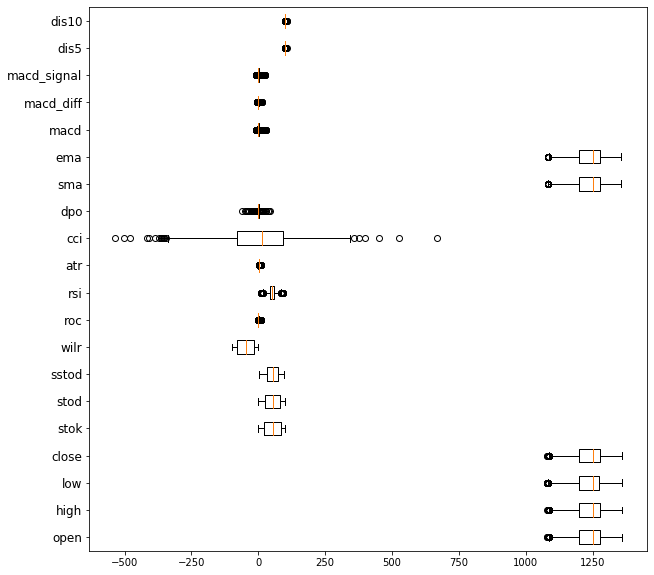

In [26]:
plt.figure(figsize=(10,10))
plt.boxplot(X.values,vert=False)
plt.yticks(np.arange(1,X.shape[1]+1),
           X.columns,fontsize=12)
plt.show()

## PreProcessed

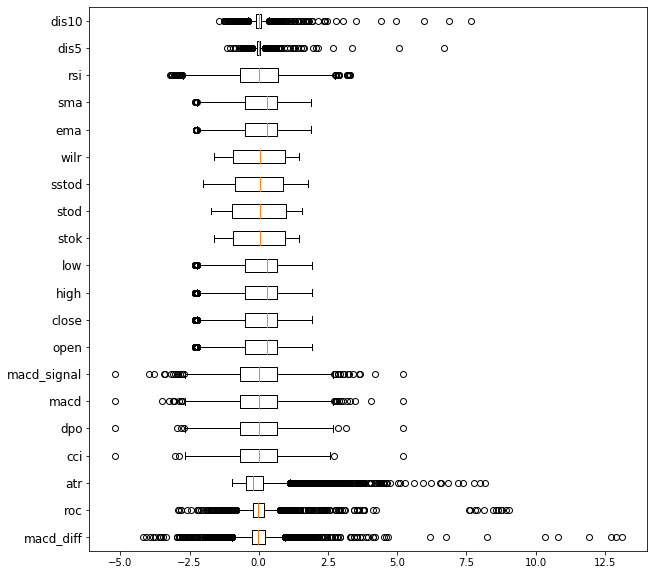

In [27]:
# tempX = tempX.drop(columns=['cci'])
plt.figure(figsize=(10,10))
plt.boxplot(preproX.values,vert=False)
plt.yticks(np.arange(1,preproX.shape[1]+1),
           preproX.columns,fontsize=12)
plt.show()

## Pre Processed 2.0

In [15]:
featurePreProcessing = {'open':'std',
                        'close':'std',
                        'high':'std',
                        'low':'std',
                        'stok':'std',
                        'stod':'std',
                        'sstod':'std',
                        'wilr':'std',
                        'ema':'std',
                        'sma':'std',
                        'dis5':'sub',
                        'dis10':'sub',
                        'macd_diff':'act',
                        'roc':'actde',
                        'atr':'actde',
                        'rsi':'std',
                        'cci':'quantgau',
                        'dpo':'quantgau',
                        'macd':'quantgau',
                        'macd_signal':'quantgau'}
ppX = pre_processing(X,featurePreProcessing,100).values

plt.figure(figsize=(10,10))
plt.boxplot(ppX.values,vert=False)
plt.yticks(np.arange(1,ppX.shape[1]+1),
           ppX.columns,fontsize=12)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'values'

<Figure size 720x720 with 0 Axes>

## Split data into train and test set

In [14]:
#X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train = X_train.reset_index(drop=True) 
X_test = X_test.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((315, 120), (36, 120), (315,), (36,))

In [15]:
featurePreProcessing = {'open':'std',
                        'close':'std',
                        'high':'std',
                        'low':'std',
                        
                        'stok':'std',
                        'stod':'std',
                        'sstod':'std',
                        'wilr':'std',
                        'ema':'std',
                        'sma':'std',
                        'dis5':'sub',
                        'dis10':'sub',
                        'macd_diff':'act',
                        'roc':'actde',
                        'atr':'actde',
                        'rsi':'std',
                        'cci':'quantgau',
                        'dpo':'quantgau',
                        'macd':'quantgau',
                        'macd_signal':'quantgau'}
ppX_train,ppX_test = pre_processing(X_train,
                                       X_test,
                                       featurePreProcessing,
                                       100)

In [16]:
ppX_train.isnull().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [17]:
ppX_test.isnull().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

## Lets test some performance

In [80]:
def performanceTesting(X,Y, cv_folds,seed,ppDict,verbose):
    # ensure expected data type
    #X = X.values.astype(np.float32)
    #Y = Y.astype(np.int)#.values
    scoreHold = []
    # nested cross-validation, this is the outer fold initialization
    kf = StratifiedKFold(n_splits=cv_folds, shuffle=True,
                            random_state=seed).split(X,Y)    

    # store training and test accuracies, best parameters, 
    # selected features, ensemble accuracies
    # total_train_acc = np.zeros(shape=(cv_folds, len(models))) 
    # total_test_acc = np.zeros(shape=(cv_folds, len(models))) 
    # total_best_params = np.zeros(shape=(cv_folds, len(models)),dtype=np.object)
    # total_features = np.zeros(shape=(cv_folds, len(models)),dtype=np.object)
    # total_ens_test_acc = np.zeros(shape=(cv_folds, 4)) # 4 different ensembles

    for counter, (train_index, test_index) in enumerate(kf):
        if verbose:
            print("Outer CV fold {}".format(counter))

    #     # create directory for output, if write_output is active
    #     if write_output:
    #         odir = os.path.join(outputdir, str(counter))
    #         if not os.path.exists(odir):
    #             os.makedirs(odir)
        #print(train_index)
        # get training/test splits
        X_train, X_test = X.loc[train_index,:].reset_index(drop=True),\
                            X.loc[test_index,:].reset_index(drop=True)
        
        Y_train, Y_test = Y[train_index], Y[test_index]

        # store predictions and errors within each outer fold
    #     total_pred_proba = np.zeros(shape=(len(test_index), len(models)))
    #     total_Y_pred = np.zeros(shape=(len(test_index), len(models)))
    #     total_Y_error_proba = np.zeros(shape=(len(test_index), len(models)))
    #     total_Y_error_class = np.zeros(shape=(len(test_index), len(models)))

    #     # store predictions on inner folds for training stacked ensembles
    #     total_inner_pred = np.zeros(shape=(len(train_index), len(models))) 
    #     total_inner_pred_proba = np.zeros(shape=(len(train_index), len(models))) 

        # initialize inner kf
    #     inner_kf = cross_validation.StratifiedKFold(Y_train, n_folds=cv_folds,
    #                                       shuffle=True, random_state = seed)
        #print(X_train.shape,X_test.shape)
        # perform pre-processing on current outer training and test set
        X_train, X_test = pre_processing(X_train, X_test, ppDict,100)
        #print(X_train.dtypes,'\n')
        #print(X_test.dtypes,'\n')
#         print(np.sum(np.sum(X_train.isnull(),axis=None)),
#               np.sum(np.sum(X_train==np.inf,axis=None)))
#         print(np.sum(np.sum(X_test.isnull(),axis=None)),
#               np.sum(np.sum(X_test==np.inf,axis=None)))
#         print(np.sum(X_train.isnull(),axis=None),
#               np.sum(X_train==np.inf,axis=None))
#         print(np.sum(X_test.isnull(),axis=None),
#               np.sum(X_test==np.inf,axis=None))
        
        clf = LogisticRegression(random_state=0,
                                 max_iter=1000,
                                 solver='lbfgs',
                                 C = 0.1).fit(X_train, Y_train)
#         clf.predict(X[:2, :])
    
        scoreHold.append(clf.score(X_test, Y_test))
    print('Scores: ',scoreHold)
    print('Average Score: %.3f (%.3f)'% (np.mean(scoreHold),np.std(scoreHold)))
        
        

### Lets test different preprocessing methods

In [81]:
for ppm in ['std','quantgau','quantuni','pow','minmax']:#'act','actde',
    print('The preprocessing method tested is: %s\n' % ppm)
    testDict = {col:ppm for col in X.columns}
    performanceTesting(X,y,5,2020,testDict,verbose=0)
    print('\n')

The preprocessing method tested is: std

Scores:  [0.3903186274509804, 0.3948497854077253, 0.3905579399141631, 0.39607602697731453, 0.38381361128142244]
Average Score: 0.391 (0.004)


The preprocessing method tested is: quantgau

Scores:  [0.3860294117647059, 0.4064990803188228, 0.39914163090128757, 0.38994481912936846, 0.37216431637032493]
Average Score: 0.391 (0.012)


The preprocessing method tested is: quantuni

Scores:  [0.39950980392156865, 0.39914163090128757, 0.3905579399141631, 0.39362354383813614, 0.3727774371551196]
Average Score: 0.391 (0.010)


The preprocessing method tested is: pow

Scores:  [0.39276960784313725, 0.39546290619251995, 0.3746167995095034, 0.3917841814837523, 0.38136112814224404]
Average Score: 0.387 (0.008)


The preprocessing method tested is: minmax

Scores:  [0.39644607843137253, 0.3825873697118332, 0.37155119558553035, 0.3911710606989577, 0.4009809932556714]
Average Score: 0.389 (0.010)




## Pre-Process features individually

In [19]:
featurePreProcessing = {'open':'std',
                        'close':'std',
                        'high':'std',
                        'low':'std',
                        'stok':'std',
                        'stod':'std',
                        'sstod':'std',
                        'wilr':'std',
                        'ema':'std',
                        'sma':'std',
                        'dis5':'sub',
                        'dis10':'sub',
                        'macd_diff':'act',
                        'roc':'actde',
                        'atr':'actde',
                        'rsi':'std',
                        'cci':'quantgau',
                        'dpo':'quantgau',
                        'macd':'quantgau',
                        'macd_signal':'quantgau'}
performanceTesting(X,y,5,2020,featurePreProcessing,verbose=0)

Scores:  [0.18309859154929578, 0.15714285714285714, 0.21428571428571427, 0.14285714285714285, 0.17142857142857143]
Average Score: 0.174 (0.024)


## Connect to SQL Database

In [26]:
server =  'fmnskln.database.windows.net' #'<server>.database.windows.net'
database = 'aggregateData'
username = 'fmnsklnucph'
password = pd.read_csv('../secrets/sql_pw.txt', header=None).values[0][0]
driver= '{ODBC Driver 17 for SQL Server}'
cnxn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password,
                     autocommit=True)
cursor = cnxn.cursor()
#cursor.execute("SELECT TOP 20 pc.Name as CategoryName, p.name as ProductName FROM [SalesLT].[ProductCategory] pc JOIN [SalesLT].[Product] p ON pc.productcategoryid = p.productcategoryid")

In [14]:
cursor.execute("SELECT * FROM Agg_1m")

In [15]:
cursor.fetchall()

[('GOOG', datetime.date(2020, 4, 1), 0, Decimal('1122.26000'), Decimal('1127.22000'), Decimal('1119.51000'), Decimal('1126.12000'), None)]

In [26]:
# works
cursor.fast_executemany = False
result = [['GOOG', '20200401', 2, 1122.26, 1127.22, 1119.51, 1126.12]]
cursor.executemany('INSERT INTO [dbo].[Agg_1m] ([ticker], [time_date], [time_group], [open_price], [high_price], [low_price], [close_price]) VALUES (?, ?, ?, ?, ?, ?, ?)', result)


In [34]:
import datetime

In [38]:
datetime.datetime.strptime('20200401','%Y%m%d') #.strftime('%Y-%m-%d') #strptime(a, '%Y%m%d').strftime('%m/%d/%Y')

'2020-04-01'

In [70]:
cursor.fast_executemany = False  # new in pyodbc 4.0.19

sql = "INSERT INTO [dbo].[Agg_1m] ([ticker], [time_date], [time_group], [open_price], [high_price], [low_price], [close_price]) VALUES (?, ?, ?, ?, ?, ?, ?)"
params = tt.values.tolist() #[['GOOG', datetime.datetime.strptime('20200401','%Y%m%d'), 5, 1122.26, 1127.22, 1119.51, 1126.12]] #[(f'txt{i:06d}',) for i in range(1000)]
t0 = time.time()
cursor.executemany(sql, params)
print(f'{time.time() - t0:.1f} seconds')

471.0 seconds


In [71]:
# try optimizing
tt = candles_pd.copy()
tt.columns = candles_pd.columns.droplevel(0)
tt.reset_index(drop=False, inplace=True)
tt.insert(loc=0, column='ticker', value='GOOG')
tt['Date'] = pd.to_datetime(tt['Date'], format='%Y%m%d') #datetime.datetime.strptime(tt['Date'],'%Y%m%d')
tt.values

array([['GOOG', Timestamp('2020-04-01 00:00:00'), 0, ..., 1127.22,
        1119.51, 1126.12],
       ['GOOG', Timestamp('2020-04-01 00:00:00'), 1, ..., 1128.0, 1120.0,
        1126.92],
       ['GOOG', Timestamp('2020-04-01 00:00:00'), 2, ..., 1127.4,
        1124.02, 1125.44],
       ...,
       ['GOOG', Timestamp('2020-04-30 00:00:00'), 387, ..., 1348.99,
        1346.75, 1348.92],
       ['GOOG', Timestamp('2020-04-30 00:00:00'), 388, ..., 1350.0,
        1348.44, 1349.94],
       ['GOOG', Timestamp('2020-04-30 00:00:00'), 389, ..., 1352.85,
        1346.0, 1348.8]], dtype=object)

In [69]:
cursor.fast_executemany = True  # new in pyodbc 4.0.19

sql = "INSERT INTO [dbo].[Agg_1m] ([ticker], [time_date], [time_group], [open_price], [high_price], [low_price], [close_price]) VALUES (?, ?, ?, ?, ?, ?, ?)"
params = tt.values.tolist() #[['GOOG', datetime.datetime.strptime('20200401','%Y%m%d'), 5, 1122.26, 1127.22, 1119.51, 1126.12]] #[(f'txt{i:06d}',) for i in range(1000)]
t0 = time.time()
cursor.executemany(sql, params)
print(f'{time.time() - t0:.1f} seconds')

50.9 seconds
